In [3]:
#Data preprocessing for time domain analysis
import numpy as np
import scipy.io
data = scipy.io.loadmat('case1_1.mat')
for i in data:
    if'__' not in i and 'readme' not in i :
        np.savetxt(("case1_1"+i+".csv"),data[i],delimiter=',')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI, Created on: Fri Feb 28 15:18:51 2014',
 '__version__': '1.0',
 '__globals__': [],
 'teeth': array([[32]], dtype=uint8),
 'ppr': array([[8]], dtype=uint8),
 'gs': array([[0.76869321],
        [0.74118978],
        [1.36261964],
        ...,
        [0.24465132],
        [1.45718968],
        [0.55262822]]),
 'sr': array([[97656]]),
 'tach': array([[6.20800000e-04],
        [5.05568000e-03],
        [9.43968000e-03],
        ...,
        [4.07955284e+01],
        [4.07996445e+01],
        [4.08037911e+01]])}

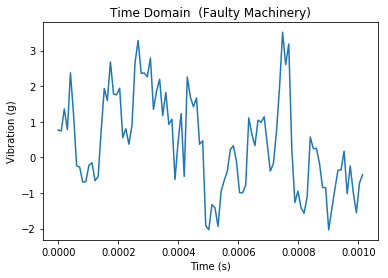

In [31]:
gs = pd.read_csv ("case1_1gs.csv",header = None)
len(gs) 
# Sampling rate and time vector
start_time = 0 # seconds
end_time = 6 # seconds
sampling_rate = 97656 # Hz
N = (end_time - start_time)*sampling_rate # array size
# Data plotting
time = np.linspace(start_time, end_time, N)
plt.plot(time[0:100], gs[0:100])
plt.xlabel('Time (s)')
plt.ylabel('Vibration (g)')
plt.title('Time Domain  (Faulty Machinery)');


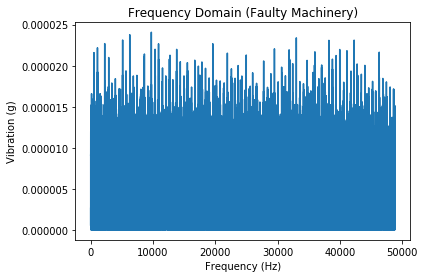

In [32]:
from scipy.fftpack import fft

# Nyquist Sampling Criteria
T = 1/sampling_rate # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# FFT algorithm
yr = fft(gs) # "raw" FFT with both + and - frequencies
y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g)')
plt.title('Frequency Domain (Faulty Machinery)');

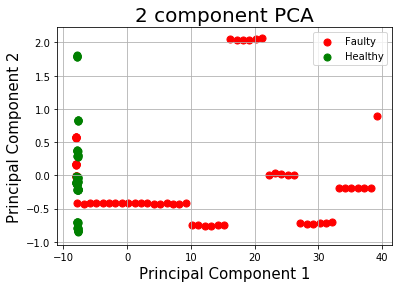

accuracy:0.86(+/-0.37)
Cross-validation scores (5-fold): [1.         1.         1.         0.75862069 0.53571429]
Mean cross-validation score (5-fold): 0.86
Predicted test data is: Faulty
Confusion Matrix:
  [[15  5]
 [ 0 16]]
Classification Report:
                precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.76      1.00      0.86        16

    accuracy                           0.86        36
   macro avg       0.88      0.88      0.86        36
weighted avg       0.89      0.86      0.86        36



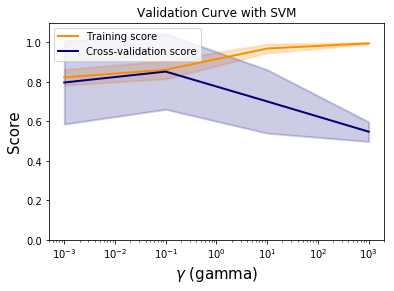

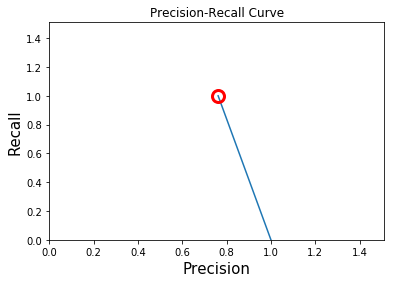

In [20]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import validation_curve
# import warnings filter
from warnings import simplefilter
#ignore all future warnings
simplefilter(action = 'ignore', category=FutureWarning)

turbinedata = pd.read_csv("dataset.csv")
lookup_data = {0 : 'Faulty', 1 : 'Healthy'} 

#model split for testing and training - std 75-25% split
X = turbinedata.drop('CLASS', axis=1)  
y = turbinedata['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

#plotting dataset using dimension reduction using PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal component 1','Principal component 2'])
finalDf = pd.concat([principalDf, turbinedata[['CLASS']]], axis = 1)
fig = plt.figure() #figsize = (8,8)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
target = [0,1]
colors = ['r', 'g']
for target, color in zip(target,colors):
    indicesToKeep = finalDf['CLASS'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Principal component 1']
               , finalDf.loc[indicesToKeep, 'Principal component 2']
               , c = color
               , s = 50)
ax.legend(['Faulty', 'Healthy'])
ax.grid()
plt.savefig('PCA of dataset.png')
plt.show()

#modeling
clf = svm.NuSVC()
clf.fit(X_train, y_train)
# grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# # metric to optimize over grid parameters: AUC
# grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
# grid_clf_auc.fit(X_train, y_train)
# y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

# print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
# print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
# print('Grid best score (AUC): ', grid_clf_auc.best_score_)

#cross validaton
scores=cross_val_score(clf,X, y,cv=5)
print('accuracy:%0.2f(+/-%0.2f)'%(scores.mean(),scores.std()*2))
print('Cross-validation scores (5-fold):', scores)
print('Mean cross-validation score (5-fold): {:0.2f}'
     .format(np.mean(scores)))

#Model Performance — Evaluation
data_predict = clf.predict([[1.1097,0.53243,0.97363,0.94796,-17.9466]])
print('Predicted test data is:',lookup_data[data_predict[0]])

#confusion matrix 
y_pred = clf.predict(X_test)
print('Confusion Matrix:\n ',confusion_matrix(y_test,y_pred))  
print('Classification Report:\n ',classification_report(y_test,y_pred))

#validation curve
param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(clf, X, y,
                                            param_name='gamma',
                                            param_range=param_range, cv=5)
plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$ (gamma)', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.savefig('validation_curve.png')
plt.show()

#precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.51])
plt.ylim([0.0, 1.51])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.title('Precision-Recall Curve')
#plt.axes().set_aspect('equal')
plt.savefig('Precision-Recall Curve.png')
plt.show()


ROC: 1.0
Probability of healthy test data is: 0.0022820752991849075
Mean squared error (SVM model): 0.13
r2_score (SVM model): 0.49


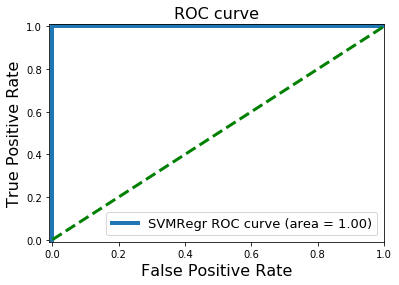

In [18]:
#Regression=>probability of failure=>amount of damage occured => health of gear
from sklearn.svm import NuSVR
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score

clf1= NuSVR()
clf1.fit(X,y)
grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# metric to optimize over grid parameters: AUC
grid_clf = GridSearchCV(clf1, param_grid = grid_values)
reg = grid_clf.fit(X_train, y_train)
y_score = clf1.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('ROC:',roc_auc)

features_name = ['RMS', 'MEAN', 'STDev', 'VARIANCE', 'KURTOSIS']
df_test = pd.read_csv('dataset_test.csv')
X_predict = clf1.predict(df_test[features_name])
data_predict1 = clf1.predict([[1.1097,0.53243,0.97363,0.94796,-17.9466]])
print('Probability of healthy test data is:',data_predict1[0])

# R^2 score 
#print('SVM model, coefficients: ', reg.coef_)
print("Mean squared error (SVM model): {:.2f}".format(mean_squared_error(y_test, y_score)))
print("r2_score (SVM model): {:.2f}".format(r2_score(y_test, y_score)))

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=4, label='SVMRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='green', lw=3, linestyle='--')
#plt.axes().set_aspect('equal')
plt.savefig('ROC curve.png')
plt.show()
